<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

---

A common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. 

Try your best to tune your model. It can be difficult, but don't worry - timeseries analysis is just a difficult and specialized topic.

In [230]:
# this will filter out a lot of future warnings from statsmodels
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [231]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [232]:
# get the dataset
data = pd.read_csv('./walmart_stores/train.csv')
data.Date=pd.to_datetime(data.Date)
data.sort_values(by='Date',inplace=True)
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,29,5,15552.08,False
2010-02-05,29,6,3200.22,False
2010-02-05,29,7,10820.05,False
2010-02-05,29,8,20055.64,False


In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


## Look back at the lesson notes for information about these models and acf/pacf plots

- [1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.](#filter)
- [2. Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?](#rolling)
- [3. Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and create an autocorrelation and partial autocorrelation plot.](#acf)
- [4. *BONUS:* What do the acf() and pacf() plots say about the type of model you want to build?](#interpretation)
- [5. Split the weekly sales data in a training and test set - using 75% of the data for training.](#train-test)
- [6. "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)](#diff)
- [7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. How effective is this model?](#AR1)
- [8. Plot the residuals - where are their significant errors?](#residuals)
- [9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?](#AR2)
- [10. Assemble your findings including any useful graphs.](#summary)

<a id='filter'></a>
### 1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [234]:
# there are about 36 different stores in this dataset.
store_1 = data[data['Store'] == 1]
store_1.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,1,49,11501.46,False
2010-02-05,1,48,814.00,False
2010-02-05,1,47,70.00,False
2010-02-05,1,51,1.16,False


In [243]:
store_1=store_1.groupby('Date').sum()[['Weekly_Sales']]

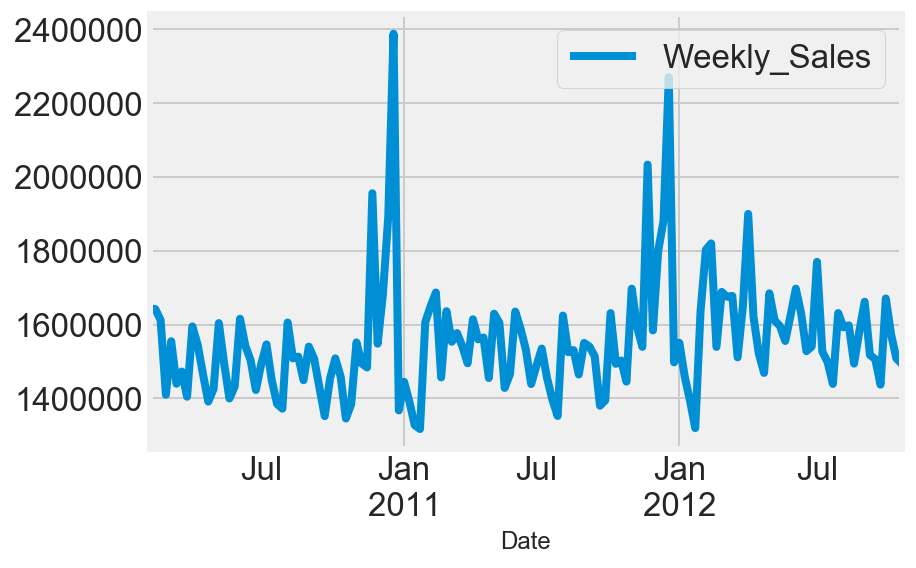

In [244]:
store_1.plot()

<a id='rolling'></a>
### 2. Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

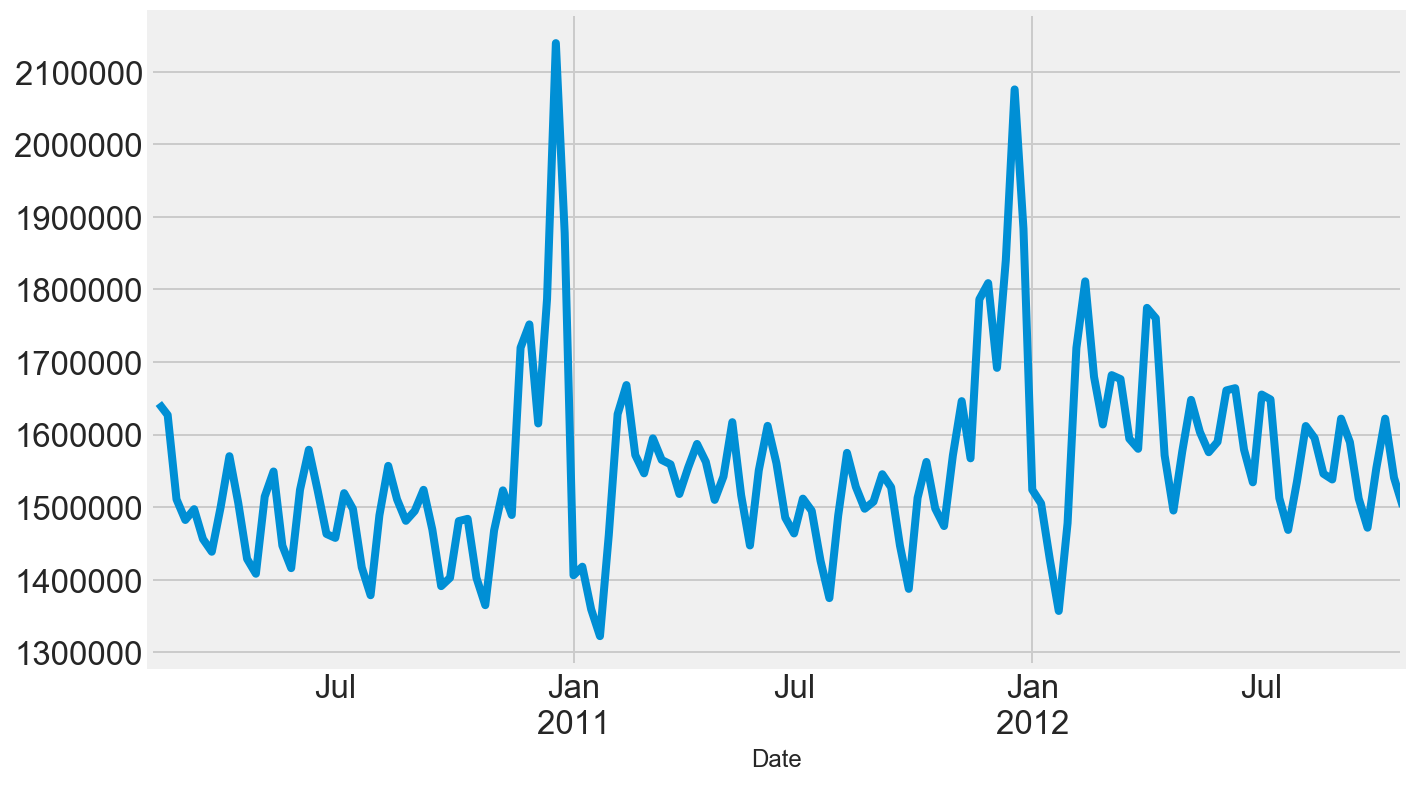

In [245]:
plt.figure(figsize=(10,6))
store_1['Weekly_Sales'].rolling(2).mean().plot();

<a id='acf'></a>
### 3. Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.

In [246]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import pacf

[1.         0.30163566]


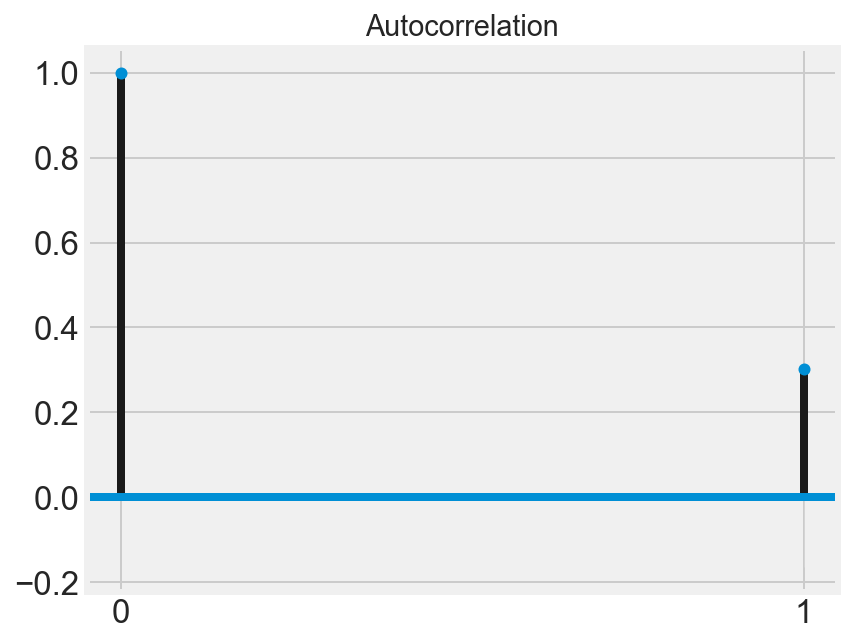

[1.         0.30375985]


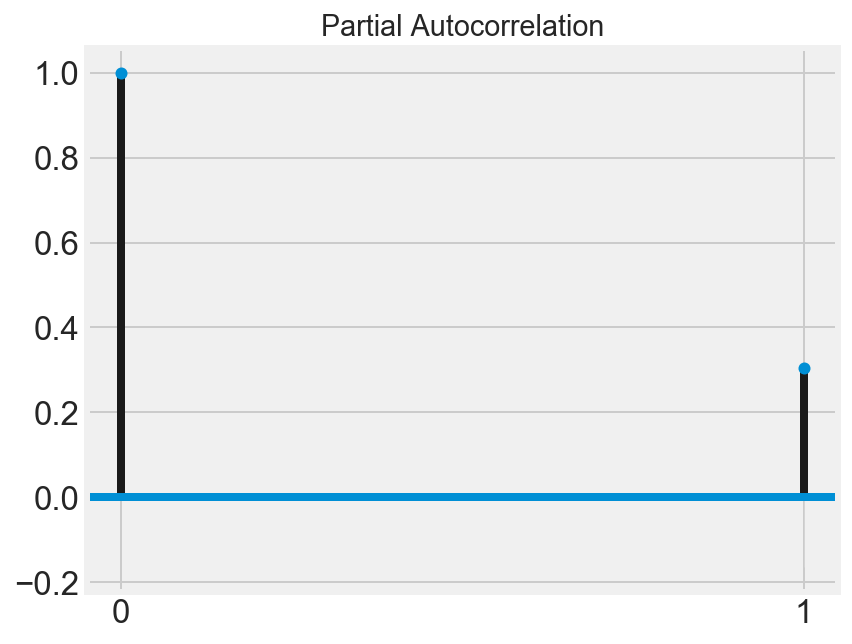

In [247]:
#k = 1
print(acf(store_1['Weekly_Sales'],nlags=1))
fig, ax = plt.subplots(figsize=(6,5))
plot_acf(store_1['Weekly_Sales'], lags=1, ax=ax)
plt.xticks(ticks = [0,1] , labels = [0,1])
plt.show()

print(pacf(store_1['Weekly_Sales'],nlags=1))
fig, ax = plt.subplots(figsize=(6,5))
plot_pacf(store_1['Weekly_Sales'], lags=1, ax=ax)
plt.xticks(ticks = [0,1] , labels = [0,1])
plt.show()

[1.         0.30163566 0.12697451]


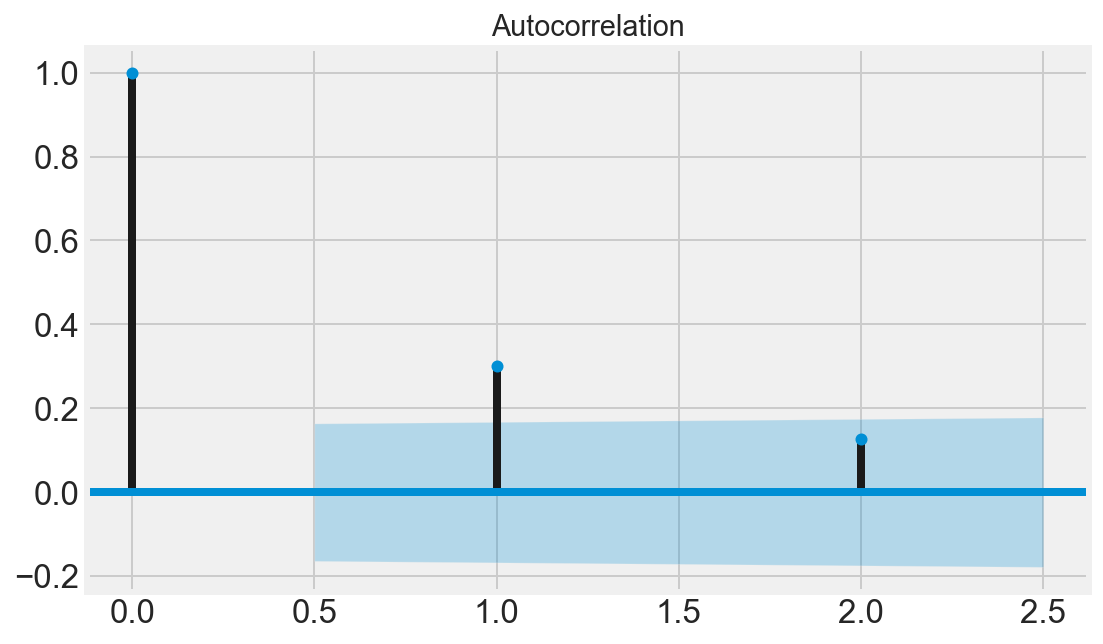

[1.         0.30375985 0.04021628]


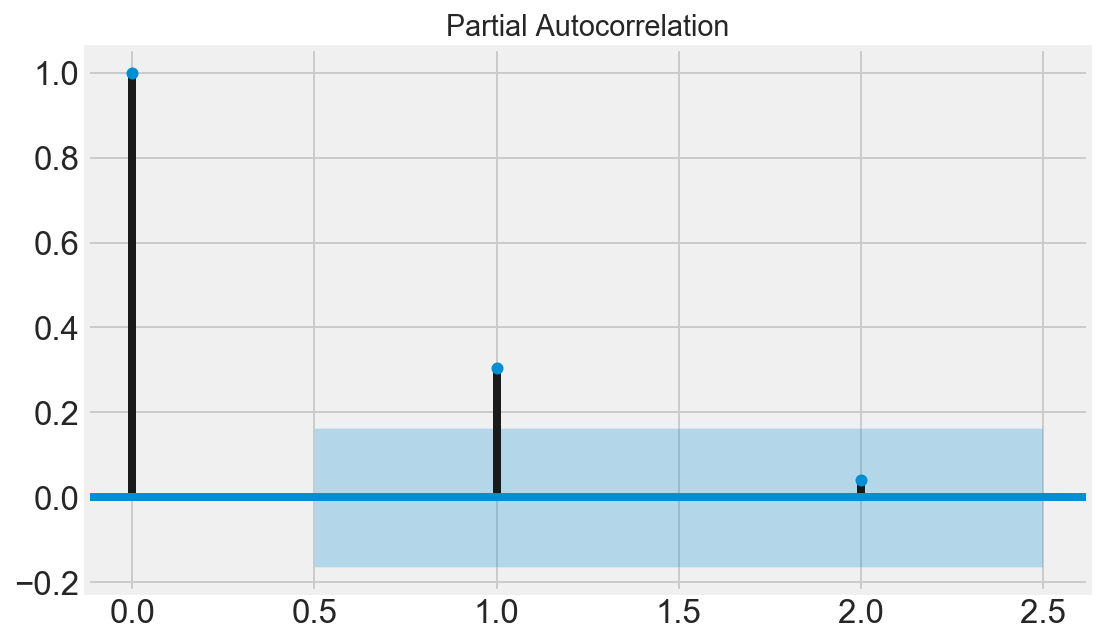

In [248]:
#k = 2
print(acf(store_1['Weekly_Sales'],nlags=2))
fig, ax = plt.subplots(figsize=(8,5))
plot_acf(store_1['Weekly_Sales'], lags=2, ax=ax)
#plt.xticks(ticks = [0,1] , labels = [0,1])
plt.show()

print(pacf(store_1['Weekly_Sales'],nlags=2))
fig, ax = plt.subplots(figsize=(8,5))
plot_pacf(store_1['Weekly_Sales'], lags=2, ax=ax)
plt.show()

[ 1.00000000e+00  3.01635656e-01  1.26974514e-01  5.95362841e-02
  2.36146134e-01 -1.21624770e-01 -9.43666039e-02  4.33021304e-02
  7.96540288e-02  4.05626132e-02  2.61507459e-02  3.56719033e-02
  7.57698431e-02  9.86570501e-02  7.17244497e-02  7.28252346e-02
  8.65362111e-02  7.69704528e-02  2.51809071e-02  9.58824335e-05
 -2.83444094e-02 -1.07344425e-01 -5.22458410e-02 -4.84047577e-02
  2.36382654e-03  2.34871667e-02  7.98347042e-02  1.10614344e-02
  4.05706731e-02 -2.05890362e-02 -9.57066504e-02 -1.49664119e-01
 -5.70961634e-02 -6.41854683e-02 -5.59343401e-02 -9.80430738e-03
 -2.69749823e-02 -3.49317807e-02 -2.00322058e-02 -3.56728029e-02
 -4.81900870e-02 -1.88981367e-02 -1.60346119e-02 -2.79736128e-02
  2.73420594e-02  3.07274025e-02 -5.81236625e-02 -1.06971550e-01
  1.15724173e-01 -2.05678893e-02  7.62648984e-03  8.01857489e-02
  4.43035248e-01]


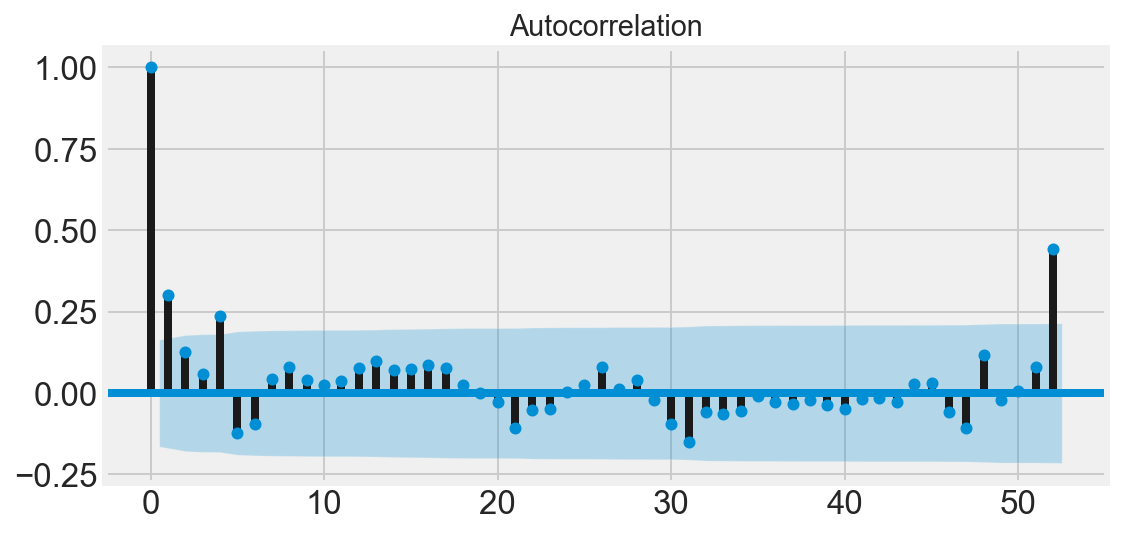

[ 1.          0.30375985  0.04021628  0.01219543  0.23927843 -0.30788835
 -0.0014493   0.14798536 -0.05206473  0.1547872  -0.03652748 -0.08797706
  0.16184013  0.03250986  0.03380417  0.10062548 -0.04966531  0.04265725
  0.02866535 -0.0672978  -0.0144685  -0.16282794  0.0307572  -0.007733
  0.001291    0.11691874 -0.03633252 -0.07070561  0.10814852 -0.16591305
 -0.11526769 -0.03760516 -0.0860713   0.0447569   0.04239275  0.00131097
 -0.07838905 -0.00120984  0.04484287 -0.09959091  0.05025263 -0.01820661
 -0.13528393  0.14544411  0.09083538 -0.02825771 -0.00447708 -0.17139392
  0.4547966  -0.33646828  0.27024814  0.43747681  0.319504  ]


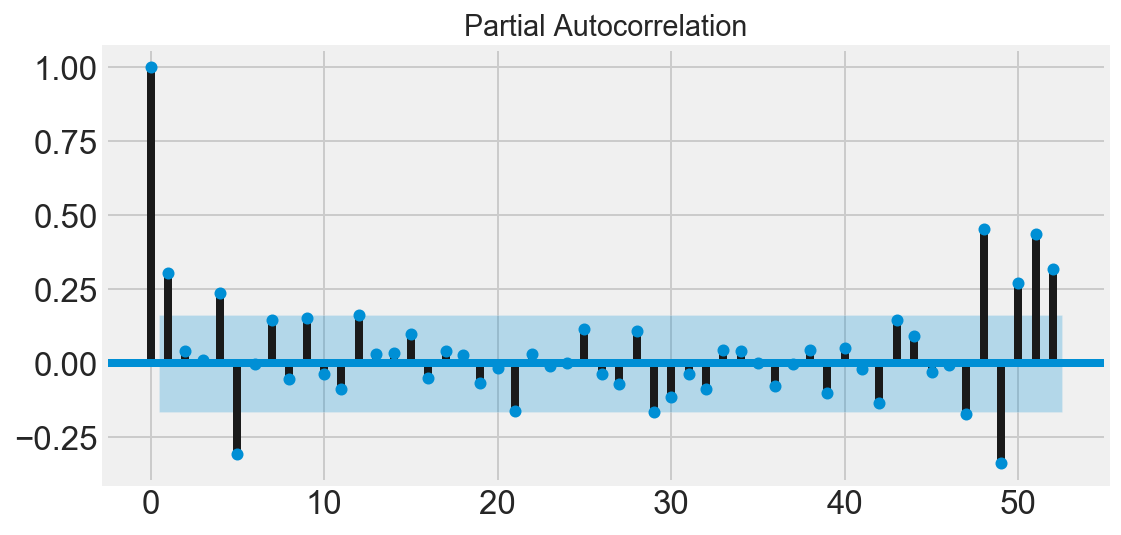

In [249]:
#k = 52
print(acf(store_1['Weekly_Sales'],nlags=52))
fig, ax = plt.subplots(figsize=(8,4))
plot_acf(store_1['Weekly_Sales'], lags=52, ax=ax)
#plt.xticks(ticks = [0,1] , labels = [0,1])
plt.show()

print(pacf(store_1['Weekly_Sales'],nlags=52))
fig, ax = plt.subplots(figsize=(8,4))
plot_pacf(store_1['Weekly_Sales'], lags=52, ax=ax)
plt.show()

<a id='interpretation'></a>
### 4. BONUS: What do the acf and pacf plots say about the type of model you want to build?


<a id='train-test'></a>
### 5. Split the weekly sales data in a training and test set - using 75% of the data for training.

In [250]:
from sklearn.model_selection import train_test_split
store_1.sort_index(inplace=True)

In [251]:
train = store_1['Weekly_Sales'].iloc[:int(store_1['Weekly_Sales'].shape[0]*0.75)]
test = store_1['Weekly_Sales'].iloc[int(store_1['Weekly_Sales'].shape[0]*0.75):]

<a id='diff'></a>
### 6. "Difference" the data by converting the sales into change in sales 

In [252]:
store_1['Weekly_Sales'].diff()

Date
2010-02-05          NaN
2010-02-12     -1733.46
2010-02-19    -29989.27
2010-02-26   -202240.58
2010-03-05    145079.09
2010-03-12   -115265.09
2010-03-19     32974.20
2010-03-26    -68085.87
2010-04-02    190538.36
2010-04-09    -49549.75
2010-04-16    -79360.25
2010-04-23    -74802.16
2010-04-30     33844.59
2010-05-07    178854.41
2010-05-14   -109703.62
2010-05-21    -94589.43
2010-05-28     32407.88
2010-06-04    183454.76
2010-06-11    -72963.62
2010-06-18    -39277.03
2010-06-25    -80572.46
2010-07-02     69706.54
2010-07-09     53656.04
2010-07-16    -97135.26
2010-07-23    -63873.72
2010-07-30    -13078.60
2010-08-06    233505.18
2010-08-13    -97254.02
2010-08-20      4842.73
2010-08-27    -63937.57
                ...    
2012-04-06    250072.25
2012-04-13   -278645.18
2012-04-20    -99453.83
2012-04-27    -52649.50
2012-05-04    215591.62
2012-05-11    -73423.94
2012-05-18    -15194.18
2012-05-25    -40457.32
2012-06-01     69033.03
2012-06-08     72753.38
2012-06-15 

<a id='AR1'></a>
### 7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. 
####    How effective is this model?

In [253]:
from statsmodels.tsa.arima_model import ARMA, ARIMA , AR
from sklearn.metrics import mean_squared_error

In [282]:
model = ARMA(train,order=(1,0)).fit()
model.summary2()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
===================================================================================
Model:                   ARMA                  BIC:                      2883.3453 
Dependent Variable:      Weekly_Sales          Log-Likelihood:           -1434.7   
Date:                    2019-08-21 16:06      Scale:                    1.0000    
No. Observations:        107                   Method:                   css-mle   
Df Model:                2                     Sample:                   02-05-2010
Df Residuals:            105                                             02-17-2012
Converged:               1.0000                S.D. of innovations:      160916.939
No. Iterations:          3.0000                HQIC:                     2878.577  
AIC:                     2875.3268                                                 
-----------------------------------------------------------------------------------
                      Coef.      Std.Err.     t    P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const              1543767.5554 22604.9559 68.2933 0.0000 1499462.6560 1588072.4548
ar.L1.Weekly_Sales       0.3147     0.0926  3.3985 0.0010       0.1332       0.4961
-------------------------------------------------------------------------------------------------
                      Real                Imaginary               Modulus               Frequency
-------------------------------------------------------------------------------------------------
AR.1                 3.1779                  0.0000                3.1779                  0.0000
===================================================================================

"""

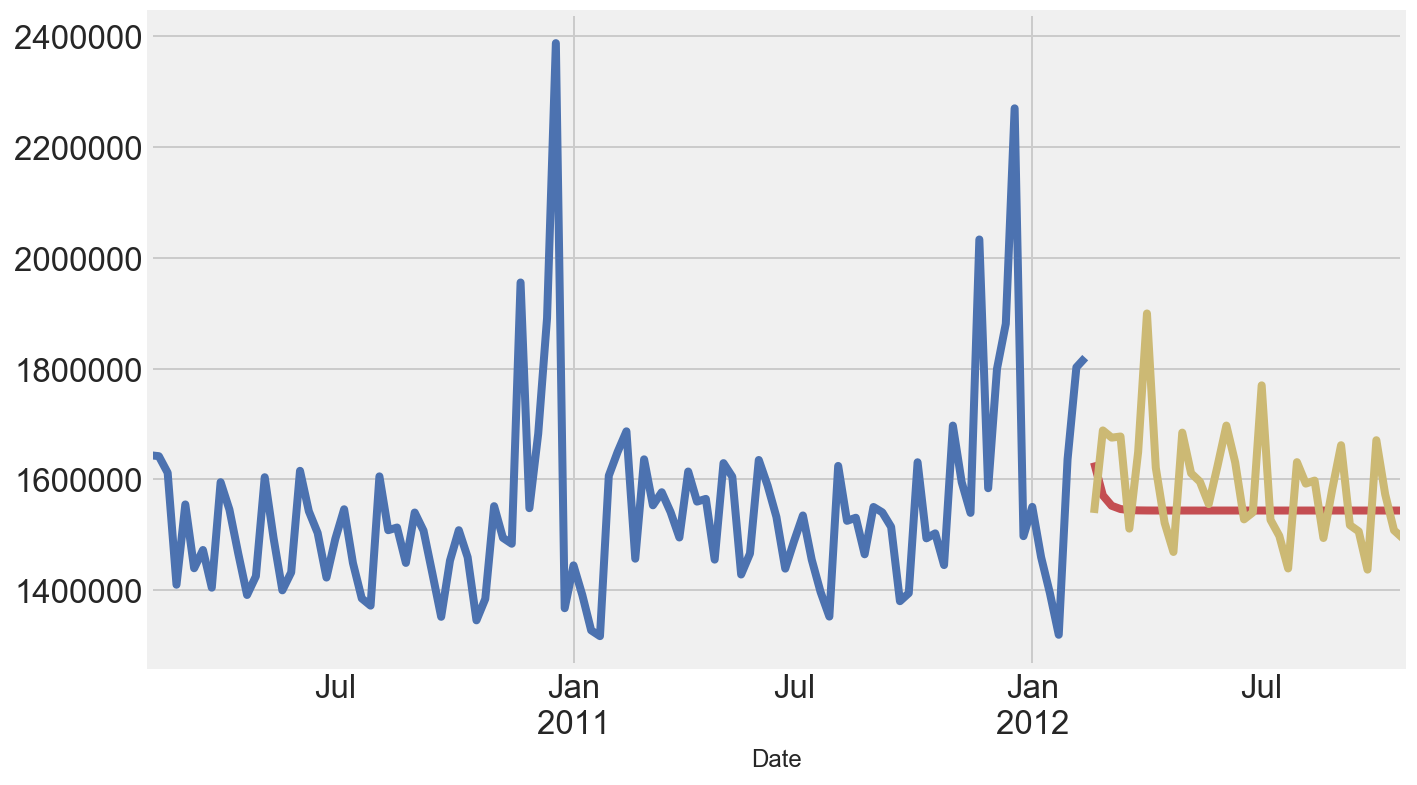

In [283]:
plt.figure(figsize=(10,6))
model.predict(start=len(train),end=len(train)+len(test)-1).plot(color='r');
train.plot(color='b');
test.plot(color='y');

In [275]:
print('MSE sklearn:\t\t', mean_squared_error(model.predict(start=len(train),end=len(train)+len(test)-1), test))
print('MSE statsmodels:\t', model.sigma2)

MSE sklearn:		 11108594679.861046
MSE statsmodels:	 25894261343.689487


<a id='residuals'></a>
### 8. Plot the residuals - where are their significant errors?

In [284]:
from scipy import stats
import statsmodels.api as sm

In [287]:
def residual_plot(res):
    resid_standard = (res - res.mean()) / res.std()

    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

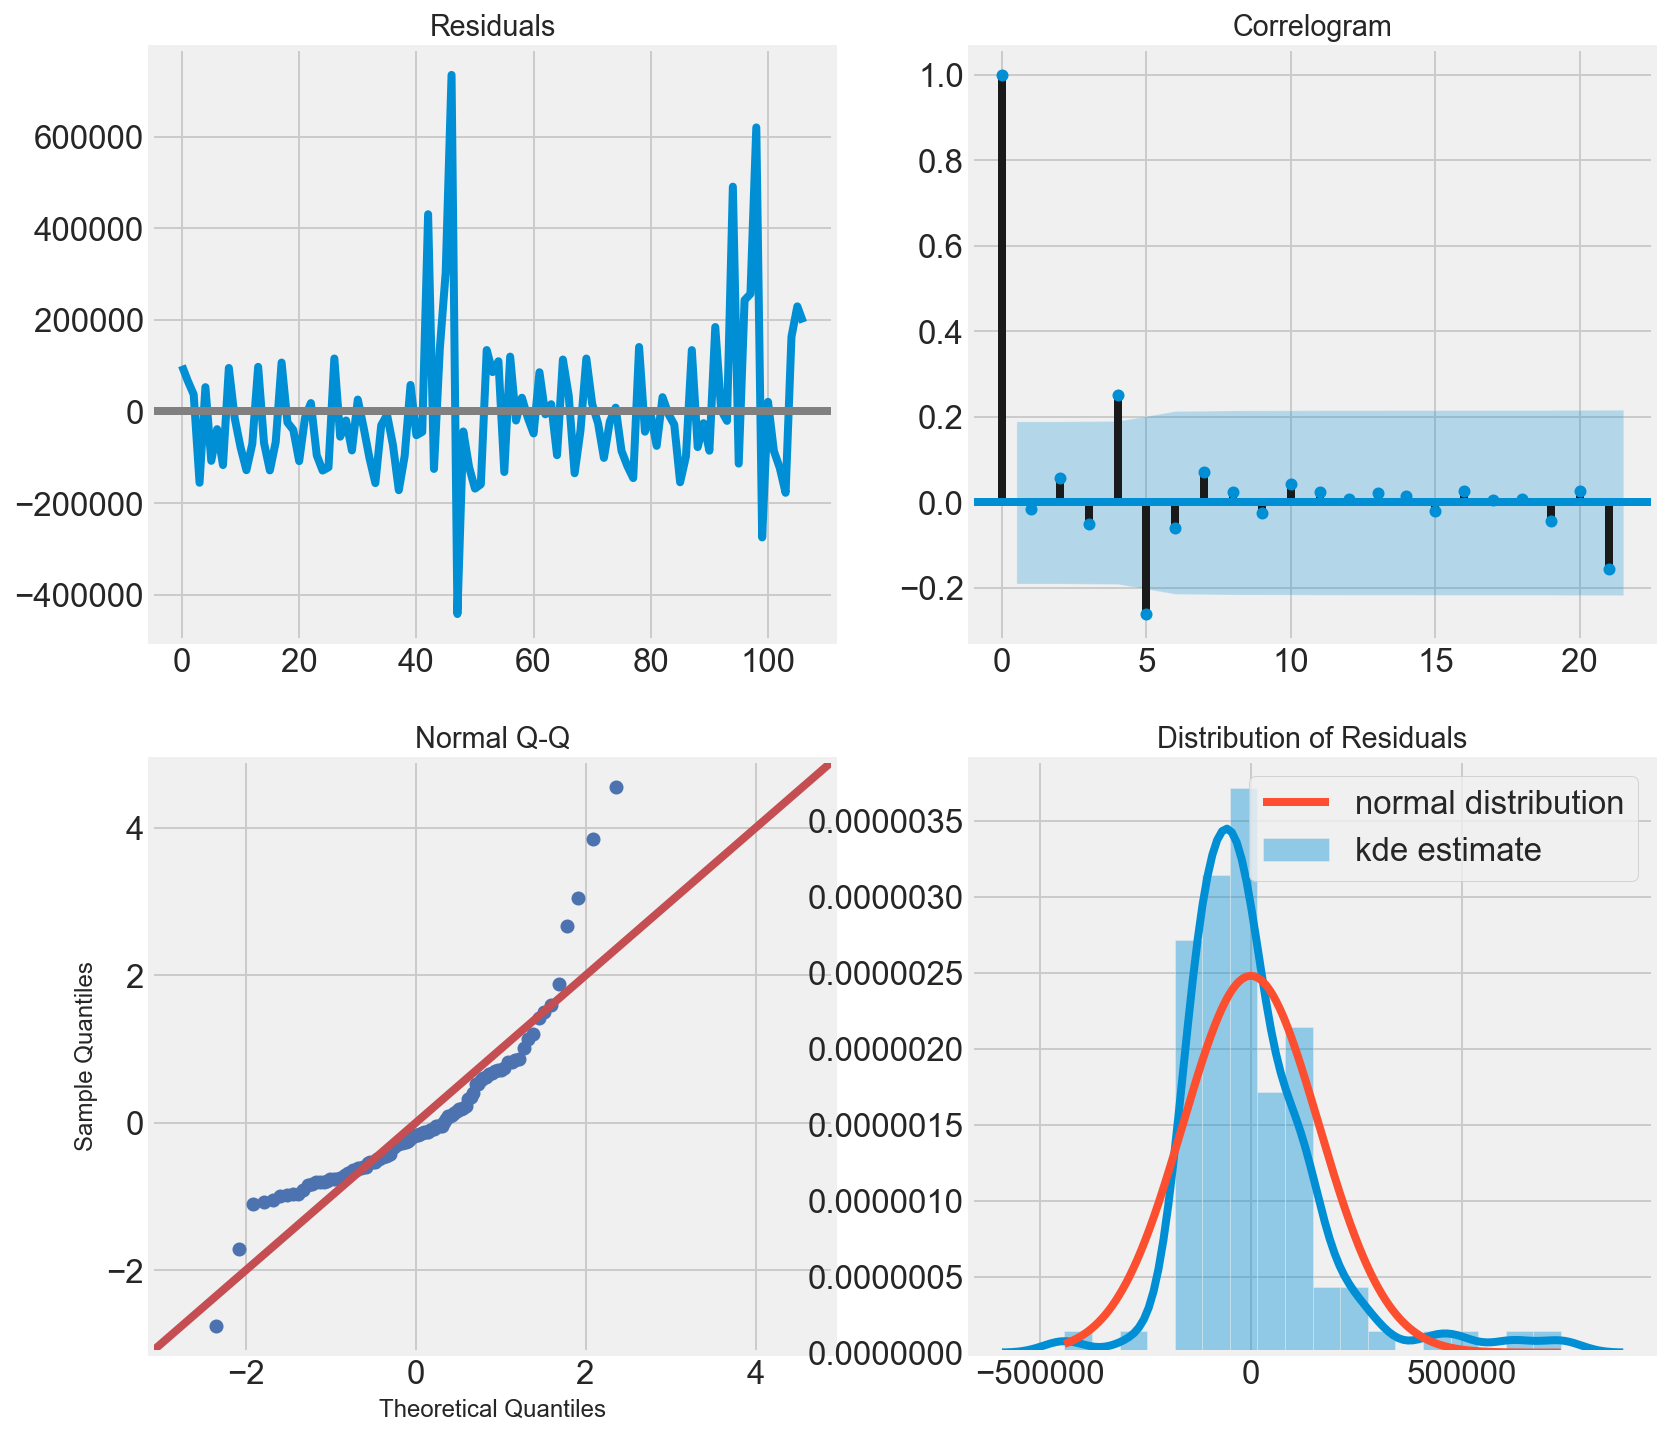

In [288]:
residual_plot(model.resid.values)

<a id='AR2'></a>
### 9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?

In [289]:
model_2 = ARMA(train,order=(2,0)).fit()
model_2.summary2()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
===================================================================================
Model:                   ARMA                  BIC:                      2887.6548 
Dependent Variable:      Weekly_Sales          Log-Likelihood:           -1434.5   
Date:                    2019-08-21 19:15      Scale:                    1.0000    
No. Observations:        107                   Method:                   css-mle   
Df Model:                3                     Sample:                   02-05-2010
Df Residuals:            104                                             02-17-2012
Converged:               1.0000                S.D. of innovations:      160638.038
No. Iterations:          5.0000                HQIC:                     2881.298  
AIC:                     2876.9635                                                 
-----------------------------------------------------------------------------------
                      Coef.      Std.Err.     t    P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const              1543767.5554 23990.4140 64.3494 0.0000 1496747.2080 1590787.9028
ar.L1.Weekly_Sales       0.2974     0.0967  3.0747 0.0027       0.1078       0.4869
ar.L2.Weekly_Sales       0.0589     0.0976  0.6032 0.5477      -0.1324       0.2502
-------------------------------------------------------------------------------------------------
                      Real                Imaginary               Modulus               Frequency
-------------------------------------------------------------------------------------------------
AR.1                 2.3080                  0.0000                2.3080                  0.0000
AR.2                -7.3587                  0.0000                7.3587                  0.5000
===================================================================================

"""

In [290]:
print('MSE sklearn:\t\t', mean_squared_error(model_2.predict(start=len(train),end=len(train)+len(test)-1), test))
print('MSE statsmodels:\t', model_2.sigma2)

MSE sklearn:		 10932676420.225458
MSE statsmodels:	 25804579273.84566


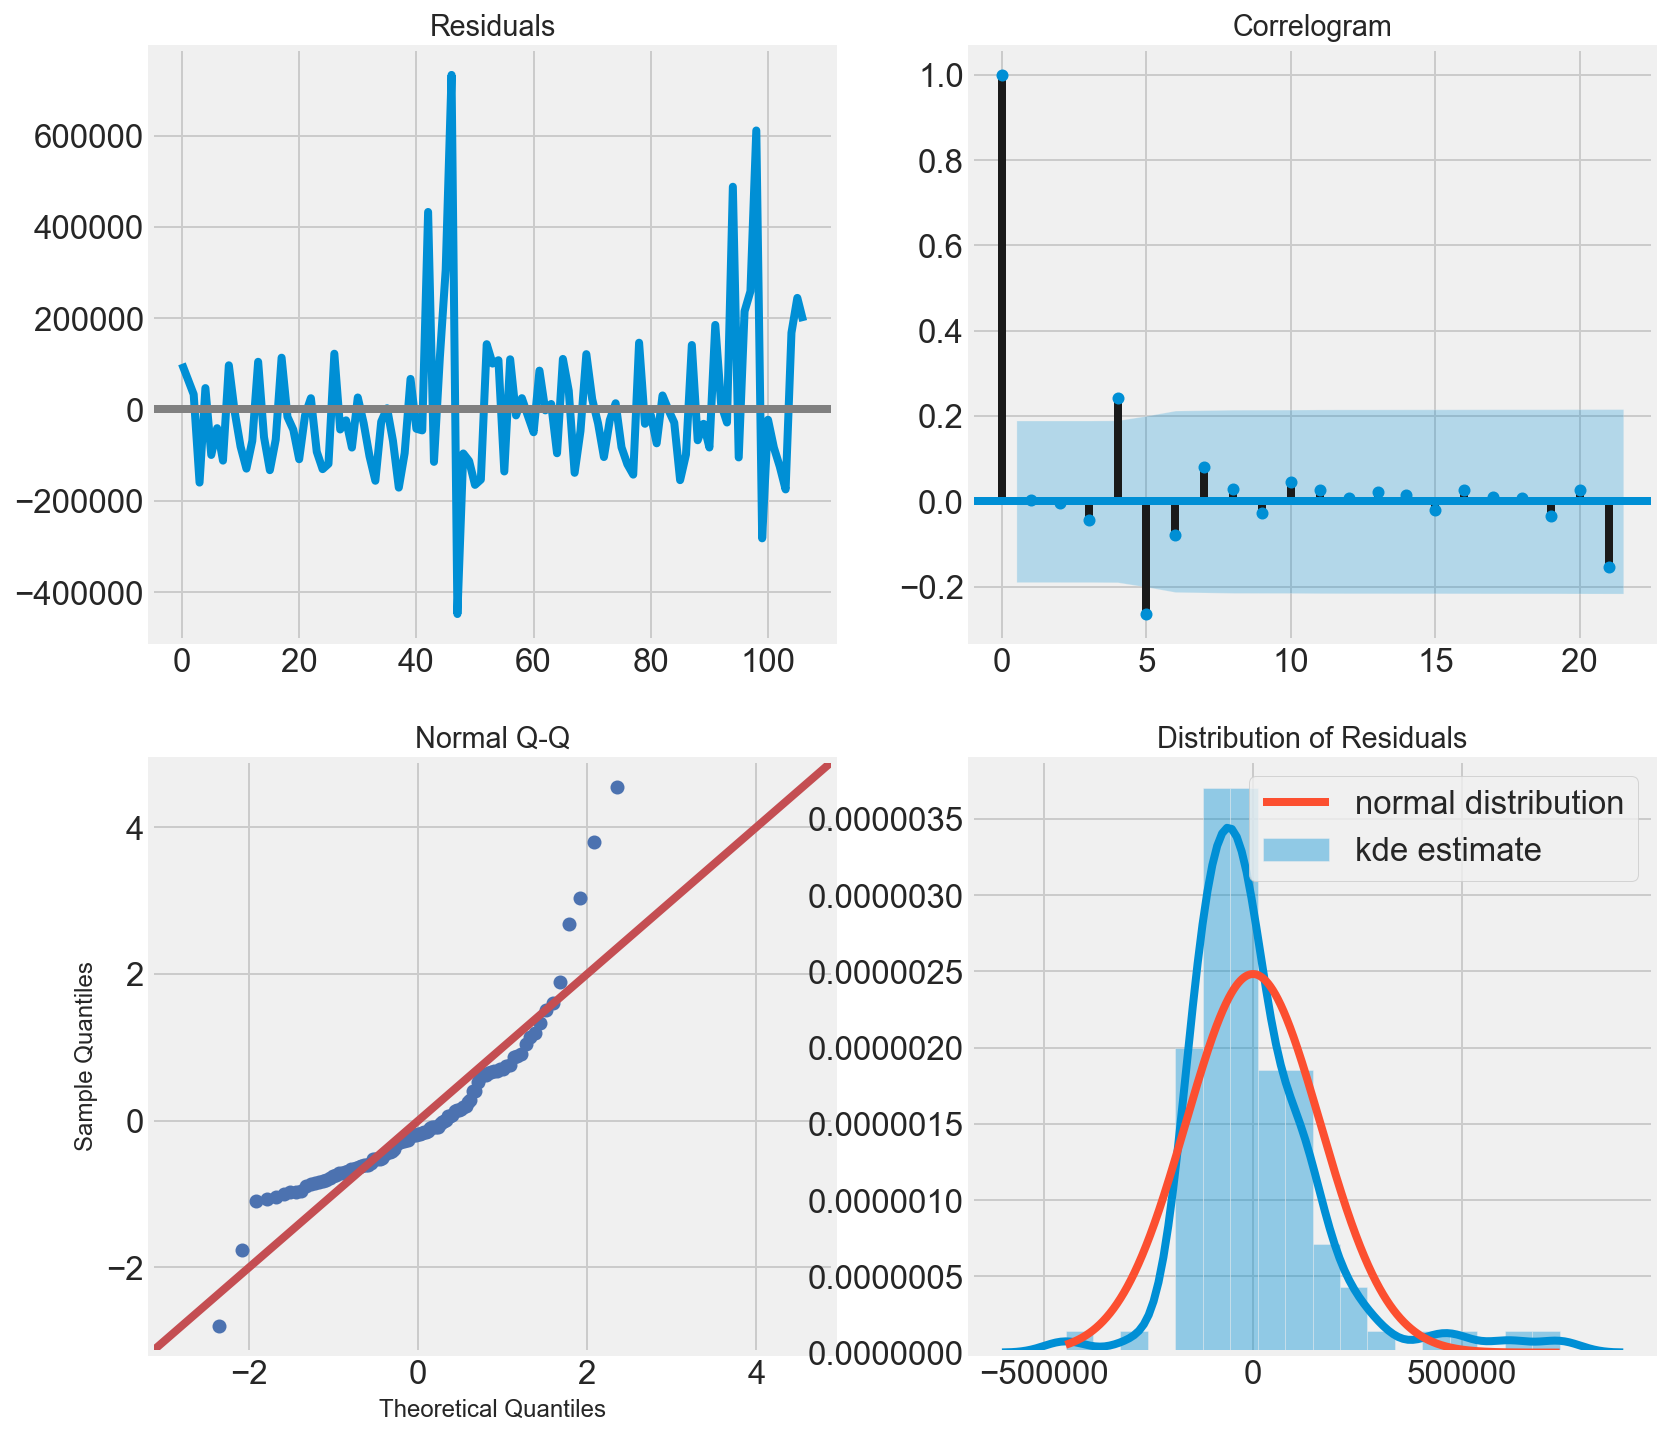

In [293]:
residual_plot(model_2.resid.values)

In [291]:
model_2_2 = ARMA(train,order=(2,2)).fit()
model_2_2.summary2()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
====================================================================================
Model:                    ARMA                  BIC:                      2879.5996 
Dependent Variable:       Weekly_Sales          Log-Likelihood:           -1425.8   
Date:                     2019-08-21 19:17      Scale:                    1.0000    
No. Observations:         107                   Method:                   css-mle   
Df Model:                 5                     Sample:                   02-05-2010
Df Residuals:             102                                             02-17-2012
Converged:                1.0000                S.D. of innovations:      144114.203
No. Iterations:           52.0000               HQIC:                     2870.064  
AIC:                      2863.5626                                                 
------------------------------------------------------------------------------------
                      Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
------------------------------------------------------------------------------------
const              1543767.5553 19220.1527  80.3203 0.0000 1506096.7483 1581438.3624
ar.L1.Weekly_Sales      -1.0398     0.0898 -11.5828 0.0000      -1.2157      -0.8638
ar.L2.Weekly_Sales      -0.4701     0.0874  -5.3795 0.0000      -0.6413      -0.2988
ma.L1.Weekly_Sales       1.4691     0.0580  25.3497 0.0000       1.3555       1.5827
ma.L2.Weekly_Sales       0.9998     0.0739  13.5329 0.0000       0.8550       1.1446
--------------------------------------------------------------------------------------------------
                       Real                Imaginary               Modulus               Frequency
--------------------------------------------------------------------------------------------------
AR.1                 -1.1059                 -0.9509                1.4585                 -0.3870
AR.2                 -1.1059                  0.9509                1.4585                  0.3870
MA.1                 -0.7347                 -0.6785                1.0001                 -0.3813
MA.2                 -0.7347                  0.6785                1.0001                  0.3813
====================================================================================

"""

In [292]:
print('MSE sklearn:\t\t', mean_squared_error(model_2_2.predict(start=len(train),end=len(train)+len(test)-1), test))
print('MSE statsmodels:\t', model_2_2.sigma2)

MSE sklearn:		 11042434840.646723
MSE statsmodels:	 20768903506.897705


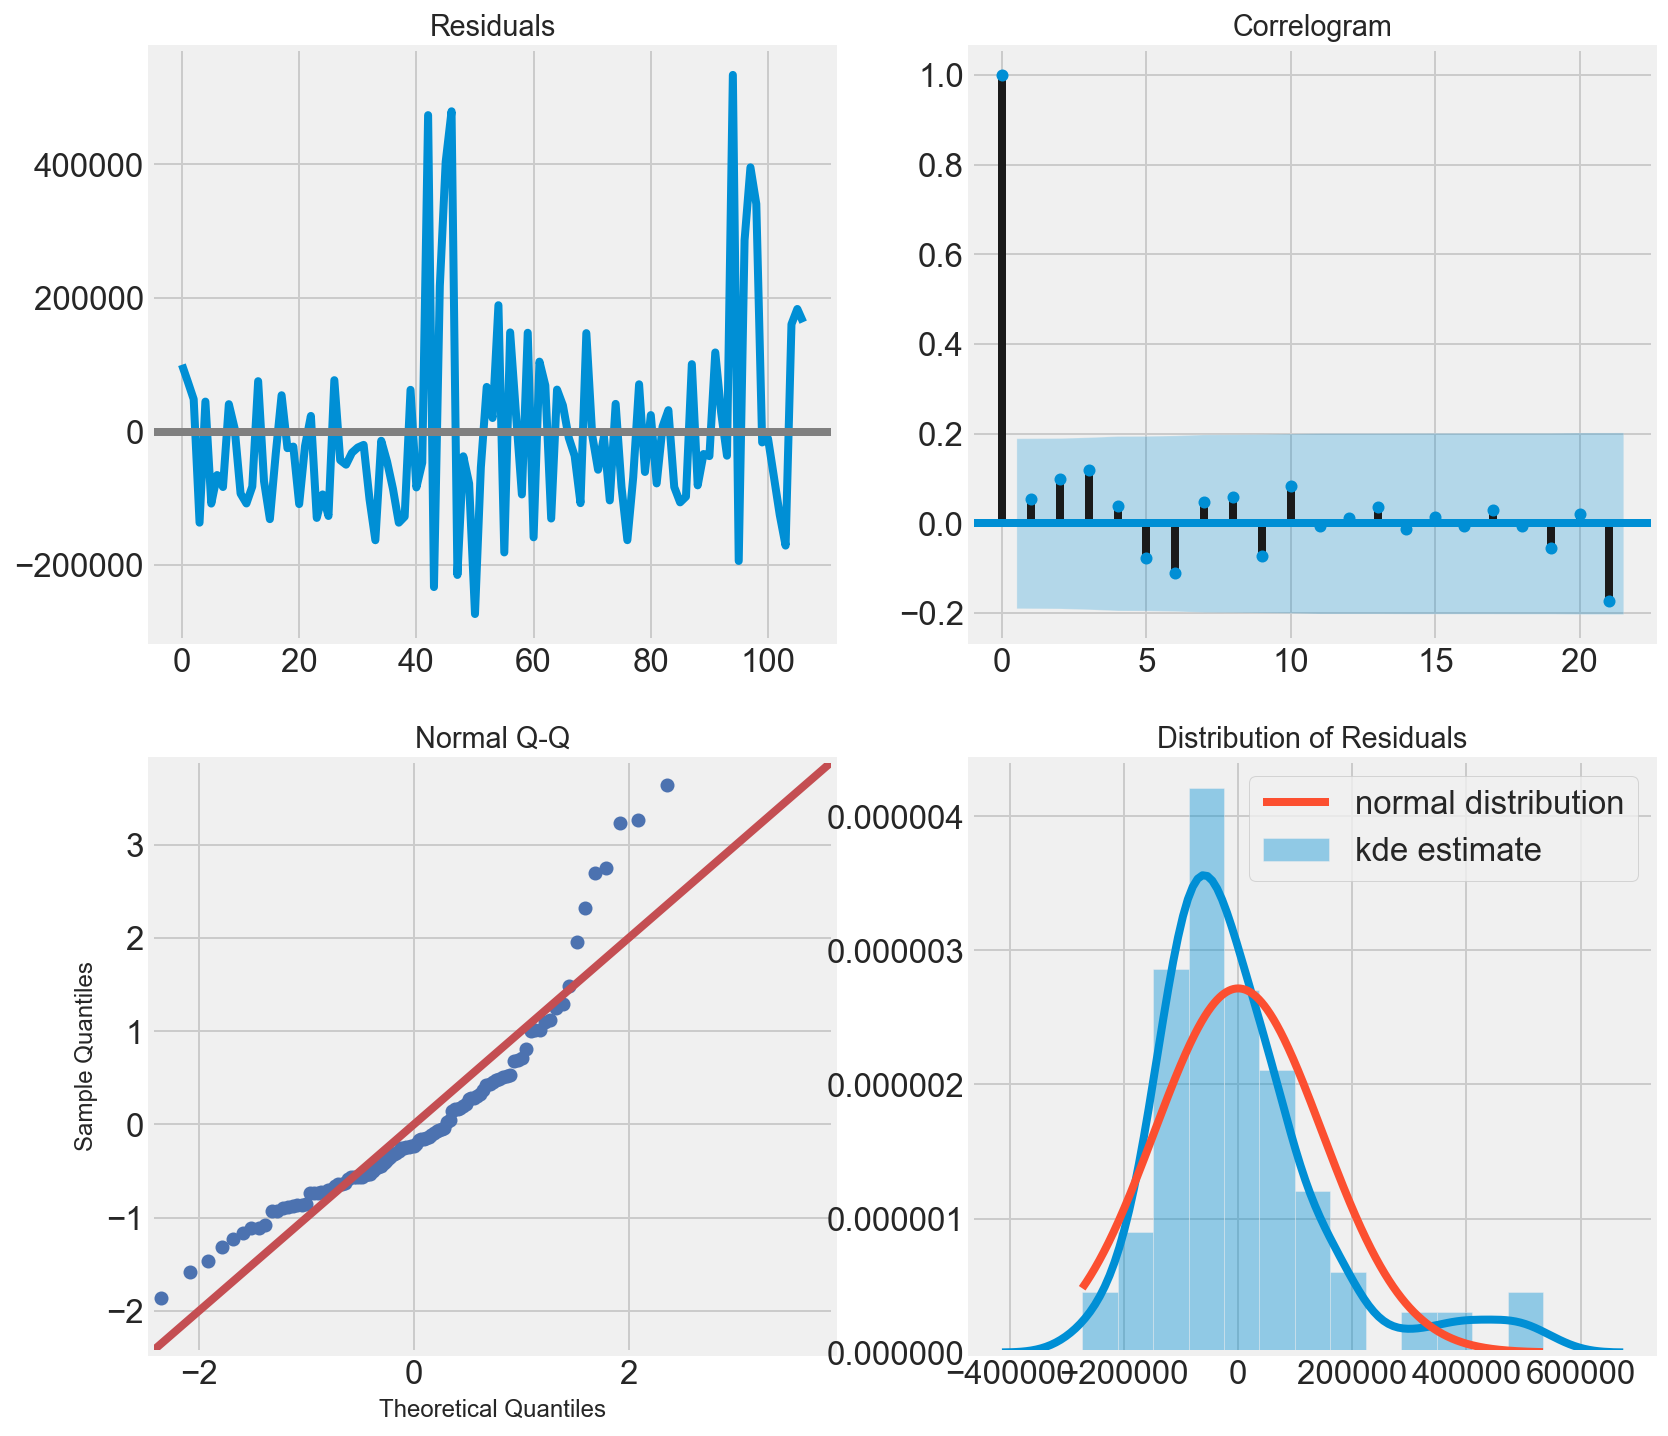

In [294]:
residual_plot(model_2_2.resid.values)

<a id='summary'></a>
### 10. Assemble your findings including any useful graphs.